### Cluster time trends in NYC Businesses

In [115]:
import pandas as pd
import numpy as np 
import matplotlib.pylab as plt
import random
import os
import json
import zipfile
import seaborn
import geopandas as gp


from sklearn.cluster import KMeans
from sklearn import mixture
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

%pylab inline


Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random', 'dist', 'plt', 'colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Data Wrangling 

#### Preparing NYC Zipcode Data

In [2]:
#get geojson data file with zipcode data 
!wget "https://github.com/fedhere/PUI2016_fb55/tree/master/HW11_fb55/nyc-zip-code-tabulation-areas-polygons.geojson	"

--2016-12-13 22:13:52--  https://github.com/fedhere/PUI2016_fb55/tree/master/HW11_fb55/nyc-zip-code-tabulation-areas-polygons.geojson%09
Resolving github.com... 192.30.253.112, 192.30.253.113
Connecting to github.com|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2016-12-13 22:13:52 ERROR 404: Not Found.



In [3]:
file = os.getenv("PUIDATA") + "/nyc.geojson"
nyczip = gp.read_file(file)

In [4]:
nyczip.head()

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,postalCode
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,2.016328e+07,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,2.260653e+07,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6.269333e+06,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,http://nyc.pediacities.com/Resource/PostalCode...,0,081,4,Bellerose,NY,36,4.941836e+07,35932.810639,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,http://nyc.pediacities.com/Resource/PostalCode...,0,081,5,Fresh Meadows,NY,36,6.938587e+07,38693.565676,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365


In [5]:
# renaming column heads 
nyczip = nyczip.rename(columns={'postalCode': "zipcode"})
nyczip = nyczip[['zipcode', 'geometry', 'borough', 'PO_NAME']]
nyczip.zipcode = pd.to_numeric(nyczip.zipcode)
nyczip.head()

,zipcode,geometry,borough,PO_NAME
0,11372,POLYGON ((-73.86942457284175 40.74915687096787...,Queens,Jackson Heights
1,11004,POLYGON ((-73.71068374074007 40.75004039450917...,Queens,Glen Oaks
2,11040,POLYGON ((-73.70098278625547 40.73889569923034...,Queens,New Hyde Park
3,11426,POLYGON ((-73.72270447144122 40.75373371438336...,Queens,Bellerose
4,11365,POLYGON ((-73.81088634744755 40.72717187575918...,Queens,Fresh Meadows


In [6]:
# confirming and sanity-proofing the number of zipcodes contained within data; should be ~250
zipvals = pd.to_numeric(nyczip.zipcode).values
unique_zipvals = np.unique(zipvals)
# nyczip['zipcode'].unique()
print ("Number of Unique zipcodes: ", unique_zipvals.shape[0])

Number of Unique zipcodes:  247


In [50]:
# print (unique_zipvals)

#### Preparing NYC Business Data 

In [10]:
!for ((y=93; y<=99; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done

!for ((y=0; y<=1; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp0$y\totals.zip; done

!for ((y=2; y<=9; y+=1)); do wget ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

!for ((y=10; y<=15; y+=1)); do wget ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done

--2016-12-14 09:32:07--  ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp93totals.zip
           => “zbp93totals.zip”
Resolving ftp.census.gov... 148.129.75.35, 2610:20:2010:a09:1000:0:9481:4b23
Connecting to ftp.census.gov|148.129.75.35|:21... connected.
Logging in as anonymous ... 
Error in server response, closing control connection.
Retrying.

--2016-12-14 09:37:11--  ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp93totals.zip
  (try: 2) => “zbp93totals.zip”
Connecting to ftp.census.gov|148.129.75.35|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /Econ2001_And_Earlier/CBP_CSV ... done.
==> SIZE zbp93totals.zip ... done.
==> PASV ... done.    ==> RETR zbp93totals.zip ... 
No such file “zbp93totals.zip”.

--2016-12-14 09:37:11--  ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp94totals.zip
           => “zbp94totals.zip.5”
Resolving ftp.census.gov... 148.129.75.35, 2610:20:2010:a09:100

In [22]:
#move zip files to PUIdata
os.system("mv zbp94totals.zip " + os.getenv("PUIDATA"))
os.system("mv zbp95totals.zip " + os.getenv("PUIDATA"))
os.system("mv zbp96totals.zip " + os.getenv("PUIDATA"))
os.system("mv zbp97totals.zip " + os.getenv("PUIDATA"))
os.system("mv zbp98totals.zip " + os.getenv("PUIDATA"))
os.system("mv zbp99totals.zip " + os.getenv("PUIDATA"))
os.system("mv zbp00totals.zip " + os.getenv("PUIDATA"))
os.system("mv zbp01totals.zip " + os.getenv("PUIDATA"))
os.system("mv zbp02totals.zip " + os.getenv("PUIDATA"))
os.system("mv zbp03totals.zip " + os.getenv("PUIDATA"))
os.system("mv zbp04totals.zip " + os.getenv("PUIDATA"))
os.system("mv zbp05totals.zip " + os.getenv("PUIDATA"))
os.system("mv zbp06totals.zip " + os.getenv("PUIDATA"))
os.system("mv zbp07totals.zip " + os.getenv("PUIDATA"))
os.system("mv zbp08totals.zip " + os.getenv("PUIDATA"))
os.system("mv zbp09totals.zip " + os.getenv("PUIDATA"))
os.system("mv zbp10totals.zip " + os.getenv("PUIDATA"))
os.system("mv zbp11totals.zip " + os.getenv("PUIDATA"))
os.system("mv zbp12totals.zip " + os.getenv("PUIDATA"))
os.system("mv zbp13totals.zip " + os.getenv("PUIDATA"))
os.system("mv zbp14totals.zip " + os.getenv("PUIDATA"))

256

In [56]:
PUIdata = os.getenv('PUIDATA')
os.chdir(PUIdata)
dfmerged = pd.DataFrame()
for y in range(94, 100):
    fname = 'zbp'+ str(y) + 'totals.zip'
    zf = zipfile.ZipFile(fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    df.columns = [x.lower() for x in df.columns]
    df['year'] = y + 1900
    df = df[df.iloc[:,0].isin(unique_zipvals)]
    dfmerged = dfmerged.append(df, ignore_index=True)

In [52]:
for y in range(2, 10):
    fname = 'zbp0'+ str(y) + 'totals.zip'
    zf = zipfile.ZipFile(fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    df.columns = [x.lower() for x in df.columns]
    df['year'] = y + 2000
    df = df[df.iloc[:,0].isin(unique_zipvals)]
    dfmerged = dfmerged.append(df, ignore_index=True)

In [88]:
for y in range(10, 15):
    fname = 'zbp'+ str(y) + 'totals.zip'
    zf = zipfile.ZipFile(fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    df.columns = [x.lower() for x in df.columns]
    df['year'] = y + 2000
    df = df[df.iloc[:,0].isin(unique_zipvals)]
    dfmerged = dfmerged.append(df, ignore_index=True)

In [89]:
# merged business and zip code data 
dfmerged.head()

,ap,ap_nf,city,cty_name,emp,emp_nf,empflag,est,name,qp1,qp1_nf,stabbr,year,zip
0,3375875,NaN,NaN,NaN,106160,NaN,NaN,6999,"New York, NY",781628,NaN,NaN,1994,10001
1,258318,NaN,NaN,NaN,13500,NaN,NaN,1784,"New York, NY",60207,NaN,NaN,1994,10002
2,2194890,NaN,NaN,NaN,59001,NaN,NaN,3256,"New York, NY",497286,NaN,NaN,1994,10003
3,2615639,NaN,NaN,NaN,39428,NaN,NaN,1115,"New York, NY",685819,NaN,NaN,1994,10004
4,2937365,NaN,NaN,NaN,43540,NaN,NaN,1076,"New York, NY",807612,NaN,NaN,1994,10005


In [91]:
dfmerged.columns

Index(['ap', 'ap_nf', 'city', 'cty_name', 'emp', 'emp_nf', 'empflag', 'est',
       'name', 'qp1', 'qp1_nf', 'stabbr', 'year', 'zip'],
      dtype='object')

#### Creating new dataframe with zipcode as the index and time as the column. 

In [94]:
dfnew = dfmerged.loc[:,['zip','year','est']]

# converting zip and year as integers 
dfnew['zip'] = dfnew['zip'].astype(int)
dfnew['year'] = dfnew['year'].astype(int)
dfnew.index = dfnew['zip']
dfnew

,zip,year,est
zip,,,
10001,10001,1994,6999
10002,10002,1994,1784
10003,10003,1994,3256
10004,10004,1994,1115
10005,10005,1994,1076
10006,10006,1994,1061
10007,10007,1994,1307
10009,10009,1994,634
10010,10010,1994,3019


In [97]:
# we will use pivot function to set zipcode as index, year as column and est as values.
dfnewpivot = dfnew.pivot_table(index='zip', columns='year', values='est')
dfnewpivot.head()

year,1994,1995,1996,1997,1998,1999,2010,2011,2012,2013,2014
zip,,,,,,,,,,,
10001,6999.0,7088.0,7075.0,7154.0,7254.0,7233.0,7241.0,7227.0,7235.0,7273.0,7369.0
10002,1784.0,1819.0,1919.0,2049.0,2003.0,2085.0,2872.0,2912.0,2954.0,2988.0,2972.0
10003,3256.0,3377.0,3417.0,3535.0,3649.0,3659.0,4113.0,4159.0,4214.0,4277.0,4333.0
10004,1115.0,1124.0,1133.0,1173.0,1176.0,1233.0,1398.0,1404.0,1442.0,1479.0,1554.0
10005,1076.0,1109.0,1216.0,1227.0,1270.0,1242.0,1266.0,1301.0,1273.0,1296.0,1321.0


#### Whitening Data - we will divide each feature by its standard deviation to decorrelate the data: it makes the features independent so that the data covariance matrix is the identity matrix. 

#### To do this, we will write a loop that will do the following: For every row, we will calculate the mean and standard deviation, then for every value, we will substract the value with mean of its respective row, and divide by standard deviation of its respective row.

In [100]:
df_final = dfnewpivot.dropna(how='any').copy()
for row in df_final.index:
    row_values = df_final.ix[row]
    row_mean = row_values.mean()
    row_std = row_values.std()
    df_final.ix[row] = (row_values - row_mean)/row_std
df_final.head()

year,1994,1995,1996,1997,1998,1999,2010,2011,2012,2013,2014
zip,,,,,,,,,,,
10001,-1.854850,-1.013767,-1.136622,-0.390043,0.554994,0.356537,0.432140,0.299834,0.375437,0.734551,1.641787
10002,-1.158188,-1.091962,-0.902743,-0.656760,-0.743800,-0.588641,0.900507,0.976195,1.055666,1.120001,1.089726
10003,-1.385285,-1.086595,-0.987854,-0.696570,-0.415159,-0.390474,0.730231,0.843783,0.979551,1.135067,1.273304
10004,-1.096276,-1.041071,-0.985867,-0.740516,-0.722114,-0.372488,0.639587,0.676390,0.909474,1.136424,1.596458
10005,-2.054459,-1.630968,-0.257828,-0.116664,0.435158,0.075832,0.383826,0.832983,0.473657,0.768818,1.089645


#### We will perform K mean clustering (elbow method) on the time series of all the zipcode. 

In [101]:
#run elbow method to determine optimal k for kmeans clustering
def elbow(data, K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

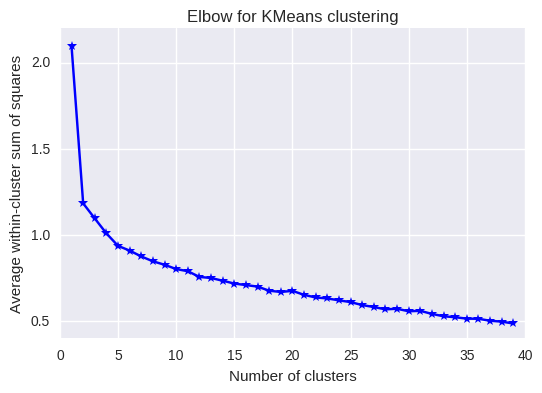

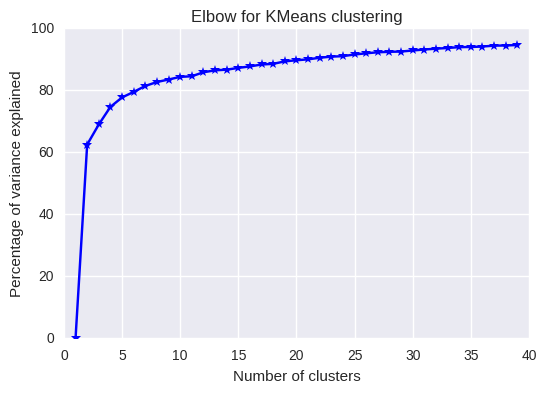

In [103]:
elbow(df_final, range(1, 40))


##### Figure 1: Elbow for KMeans clustering shows that the plot drops around k=3 

In [105]:
#group zipcodes with kmeans method
n = 3 # number of clusters

#train the model.
km = KMeans(random_state=123, n_clusters=n)
res = km.fit(df_final)
#result.
print(res.labels_)
#print res.predict(dd)
print(km.cluster_centers_)

[0 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 1 0 2 1 1 1 2 2 1 2 1 1 0 0 1 0 2 1 1 1 0 1 1 2 0 0 2 0 1 1 0 2 1 1 0
 1 1 0 1 1 2 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 2 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]
[[-1.10476198 -0.98790236 -0.86719509 -0.67333639 -0.57794934 -0.52950838
   0.65967019  0.75333325  0.92954745  1.11644861  1.28165405]
 [ 0.33155185  0.5382066   0.6400225   0.79204141  0.86318198  0.91166803
  -0.69152614 -0.88830768 -0.85282043 -0.82306752 -0.8209506 ]
 [ 0.938863    0.49833706 -0.19220844 -0.84580701 -0.9780481  -0.5700405
  -0.26555394 -0.04719672  0.21836741  0.42980599  0.81348125]]


In [107]:
#add kmeans groups label
df_final['kmeans_group'] = res.labels_

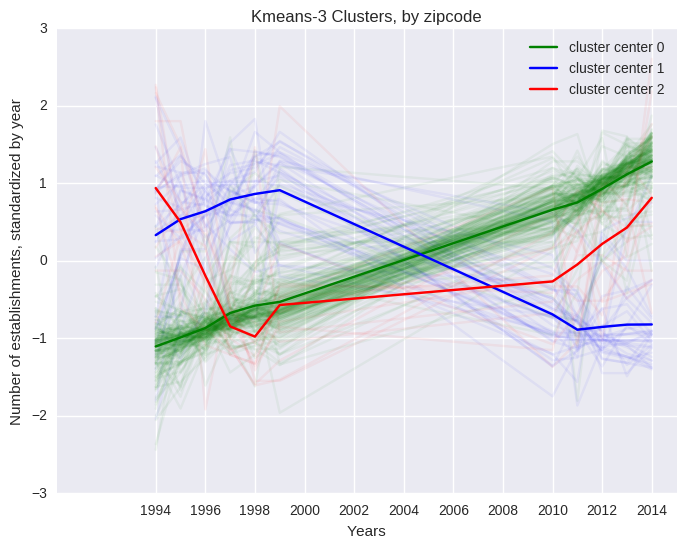

In [110]:
#plotting the data and the cluster centers
fig = plt.figure(1, figsize=(8, 6))
colors = ['green', 'blue', 'red']
val = [int(j) for j in df_final.columns[0:-1]]

for i in range(len(df_final)):
    plt.plot(val, df_final.iloc[i,:-1], c=colors[df_final.kmeans_group.iloc[i]], alpha=0.05, 
             label='_zipcode time series')  


plt.plot(val, km.cluster_centers_[0], c=colors[0], label='cluster center 0')
plt.plot(val, km.cluster_centers_[1], c=colors[1], label='cluster center 1')
plt.plot(val, km.cluster_centers_[2], c=colors[2], label='cluster center 2')

plt.ylabel('Number of establishments, standardized by year')
plt.xlabel('Years')
plt.xticks((np.arange(1994,2015,2)))
plt.title("Kmeans-{} Clusters, by zipcode".format(n))
plt.legend()

Figure 2: The plot above shows the number of businesses over the years (standardized). The zipcodes are clustered into 3 groups with the kmeans method and each group is represented by a color. The darkest part of the lines represent the centers of cluster.

#### We will use another clustering algorithm: Gaussian Mixture Method

In [126]:
random.seed(123)
n = 3 # number of clusters

#train the model.
g = mixture.GMM(n_components=n,random_state=324)
gg = g.fit(df_final.iloc[:,0:-1])

#result.
print (gg.fit_predict(df_final.iloc[:,0:-1]))

#centers
print (gg.means_)

[2 1 1 1 2 0 1 1 2 1 2 0 2 2 0 1 0 2 0 0 1 2 1 1 1 2 1 1 1 1 1 1 1 2 1 0 1
 1 1 0 1 2 0 0 0 2 2 0 2 0 0 2 2 0 1 2 0 0 0 2 0 0 2 2 2 2 2 0 0 2 2 0 2 1
 2 0 2 0 0 2 0 0 2 2 2 2 0 1 0 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1
 1 2 1 1 2 1 2 1 1 1 2 2 1 2 1 1 2 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 2 1 1 2
 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1 2 1 2 1 1 1 2 1 1 1
 1 1 2 1 1 1 1 2]
[[ 0.52656485  0.7851729   0.72440047  0.8286502   0.8674484   0.93367594
  -0.74050761 -0.86669221 -1.01137449 -1.03177556 -1.0155629 ]
 [-1.08387612 -0.98526559 -0.88966079 -0.75057527 -0.67231546 -0.62983268
   0.68158005  0.80896952  0.98554367  1.18849976  1.3469329 ]
 [-0.60174361 -0.58872824 -0.51991856 -0.37695263 -0.28119521 -0.14284988
   0.25523022  0.22855749  0.49940585  0.66089907  0.86729551]]


In [127]:
#add gaussian mixture groups label
df_final['gaussian_mix_group'] = gg.fit_predict(df_final.iloc[:,0:-1])

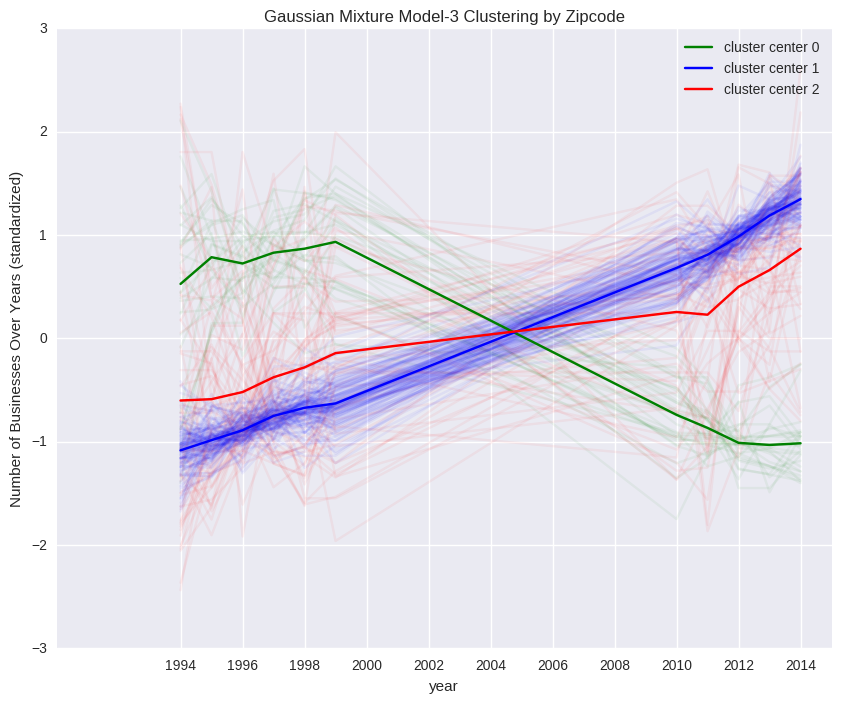

In [128]:
#plot the data and the cluster centers
fig = plt.figure(1, figsize=(10, 8))
colors = ['green', 'blue', 'red']
val = [int(j) for j in df_final.columns[0:-2]]

for i in range(len(df_final)):
    plt.plot(val, df_final.iloc[i,:-2], c=colors[df_final.gaussian_mix_group.iloc[i]], 
             alpha=0.05, label='_zipcode time series')  


plt.plot(val, gg.means_[0], c=colors[0], label='cluster center 0')
plt.plot(val, gg.means_[1], c=colors[1], label='cluster center 1')
plt.plot(val, gg.means_[2], c=colors[2], label='cluster center 2')

plt.ylabel('Number of Businesses Over Years (standardized)')
plt.xlabel('year')
plt.xticks((np.arange(1994,2015,2)))
plt.title("Gaussian Mixture Model-{} Clustering by Zipcode".format(n))
plt.legend()
plt.show()

Figure 3: The plot shows the number of businessesover each year (standardized). Each gaussian group is a different color. The darkest lines are the cluster centers. There isn't a significant clustering shift between kmeans and gaussian.

#### Overlaying data on a NYC map

In [132]:
nycmap = nyczip

In [136]:
nycmap.head()

,zipcode,geometry,borough,PO_NAME
0,11372,POLYGON ((-73.86942457284175 40.74915687096787...,Queens,Jackson Heights
1,11004,POLYGON ((-73.71068374074007 40.75004039450917...,Queens,Glen Oaks
2,11040,POLYGON ((-73.70098278625547 40.73889569923034...,Queens,New Hyde Park
3,11426,POLYGON ((-73.72270447144122 40.75373371438336...,Queens,Bellerose
4,11365,POLYGON ((-73.81088634744755 40.72717187575918...,Queens,Fresh Meadows


In [137]:
nycmap['zipcode_int'] = nycmap['zipcode'].astype(int)

In [145]:
df_final_pivot = df_final[['kmeans_group', 'gaussian_mix_group']]
nycmap_k_g = nycmap.merge(df_final_pivot, left_on='zipcode_int', right_index=True)
nycmap_k_g.head()

,zipcode,geometry,borough,PO_NAME,zipcode_int,kmeans_group,gaussian_mix_group
0,11372,POLYGON ((-73.86942457284175 40.74915687096787...,Queens,Jackson Heights,11372,0,1
1,11004,POLYGON ((-73.71068374074007 40.75004039450917...,Queens,Glen Oaks,11004,0,1
2,11040,POLYGON ((-73.70098278625547 40.73889569923034...,Queens,New Hyde Park,11040,0,2
3,11426,POLYGON ((-73.72270447144122 40.75373371438336...,Queens,Bellerose,11426,2,2
4,11365,POLYGON ((-73.81088634744755 40.72717187575918...,Queens,Fresh Meadows,11365,0,1


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


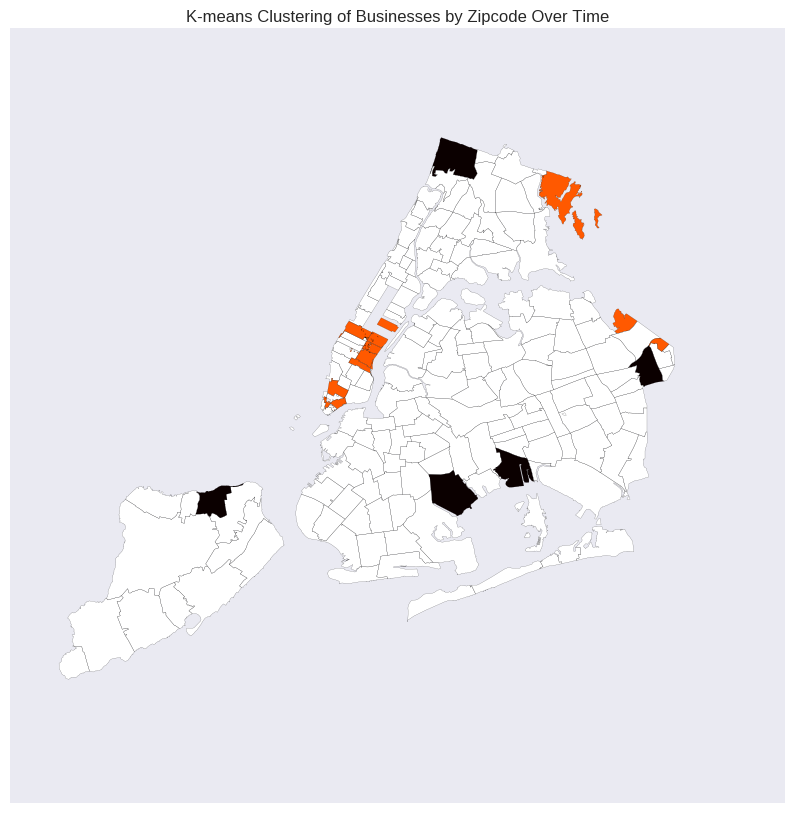

In [156]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
nycmap_k_g.plot(column='kmeans_group',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("K-means Clustering of Businesses by Zipcode Over Time")

Figure 4: The plot illustrates kmeans clustering of the number of businesses for each NYC zipcode between 1994-2014.

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


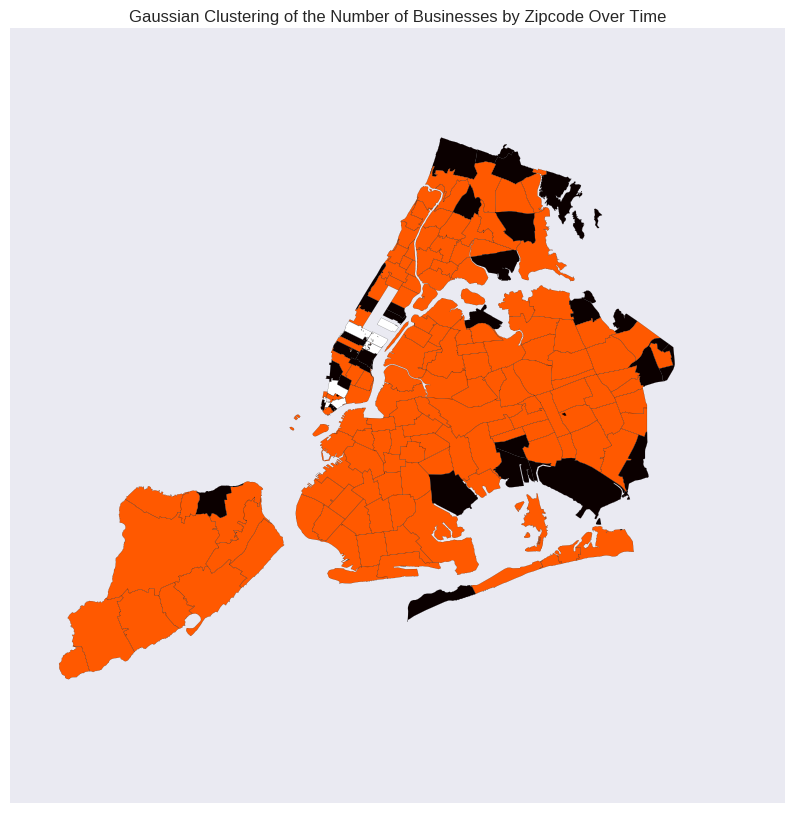

In [158]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
nycmap_k_g.plot(column='gaussian_mix_group',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Gaussian Clustering of the Number of Businesses by Zipcode Over Time")

Figure 5: The plot gaussian mixture method clustering results of the number of businesses for each zipcode for each year between 1994-2014.

### Interpreting the Results 

When comparing the two models, we see that for both models, the highest group has a downward trend, meaning the highest number of business establishments also decrease overtime. 